In [1]:
import tifffile

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
from medpy.io import load as medload

Description of the backward and forward transformations of the image. While forward transformation was a real transformation, the backward is an attempt to transform both image and markup as close to the original as possible.
It is yet to inverse some of the transformations to the original

## Forward transform:
1) crop image along z axis as [z0-50:z1+50]
2) reverse z axis
3) scale x0.5 (bilinear interpolation)
4) crop x and y axes with [y0:y0+height, x0:x0+width] where parameters are taken from makeRectangle(x0, y0, width, height);

## Backward transform:
1. get original size of the image as *o_size*
3. inverse z-axis
2. position volume inside the box [z1+50:z0-50, x0:x0+width, y0:y0+height] from file inside empty volume of size *o_size*


In [6]:
# list of the files which have sources and described transformations
!ls /mnt/data/machine-learning/medaka_align/

508_33-1_align.nii     671_80-1_trans.hx      828_4-2_trans.hx
508_33-1_align.tif     672_80-1_align.nii     833_14-2_align.nii
508_33-1_trans.hx      672_80-1_align.tif     833_14-2_align.tif
509_33-1_align.nii     672_80-1_trans.hx      833_14-2_trans.hx
509_33-1_align.tif     673_80-1_align.nii     834_14-2_align.nii
509_33-1_trans.hx      673_80-1_align.tif     834_14-2_align.tif
511_33-1_align.nii     673_80-1_trans.hx      834_14-2_trans.hx
511_33-1_align.tif     674_80-1_align.nii     835_14-2_align.nii
511_33-1_align_v2.nii  674_80-1_align.tif     835_14-2_align.tif
511_33-1_align_v2.tif  674_80-1_trans.hx      835_14-2_trans.hx
511_33-1_trans.hx      675_80-1_align.nii     853_22-1_align.nii
513_33-1_align.nii     675_80-1_align.tif     853_22-1_align.tif
513_33-1_align.tif     675_80-1_trans.hx      853_22-1_trans.hx
513_33-1_trans.hx      677_80-1_align.nii     910_43-2_align.nii
515_33-1_align.nii     677_80-1_align.tif     910_43-2_align_v2.nii
515_33-1_align.tif     677_8

In [7]:
# here is the list of the markups available to train for eyes
!ls /mnt/HD-LSDF/Medaka/segmentations/workshop/eyes_to_train

01-508.nii   04-513.nii  11-509.nii   12-675.nii   15-516.nii  18-835.nii
02-509.nii   05-515.nii  11-674.nii   13-513.nii   15-803.nii  21-675.nii
03-511.nii   08-671.nii  12-1099.nii  13-677.nii   17-671.nii  21-833.nii
04-1258.nii  10-673.nii  12-511.nii   15-1260.nii  17-834.nii  22-675.nii


In [8]:
import pandas as pd
import numpy as np
import torch
import re
from skimage.transform import resize

In [9]:
inner_medload = lambda a: np.swapaxes(medload(a)[0], 0, -1)

Next, we will load the xlsx file containing the cropping parameters and make some formatting, to have it as a convenient table

In [57]:
data = pd.read_excel('20200918_Medaka_workshop_update_ae_v5.xlsx', header=1)
data = data[['Unnamed: 5', 'XY', 'XY.1', 'crop on x0.5 rescaled']]
data = data.dropna()
data = data.rename(columns={'Unnamed: 5':'name', 'XY':'z0', 'XY.1':'z1', 'crop on x0.5 rescaled':'box'})
data['box'] = data['box'].apply(lambda x: eval(re.findall('makeRectangle(.*);', x)[0]))
data['z0'] = data['z0'].astype(int)
data['z1'] = data['z1'].astype(int)
data = data.set_index('name')
data.head()

z0    z1                 box
name                                           
Medaka_508_33-1  3807  2490   (19, 8, 484, 478)
Medaka_509_33-1  4028  2586  (55, 33, 454, 501)
Medaka_511_33-1  3500  2193  (84, 22, 439, 404)
Medaka_513_33-1  3172  1997   (6, 18, 367, 457)
Medaka_515_33-1  3747  2429  (10, 67, 434, 441)

In [11]:
from glob import glob
import os

In [74]:
all_markups = glob('/mnt/HD-LSDF/Medaka/segmentations/workshop/corrected_brains/*.nii')

In [13]:
def backward_transform(img, o_shape, z0, z1, box):
    """
    Direct decropping function
    """
    transported = np.zeros(np.array(o_shape)//2, dtype=np.uint8)
    x0, y0, width, height = box
    z0, z1 = max(z1, 0)//2, min(z0, o_shape[0]-1)//2
    diff = (z1-z0) - img.shape[0]
    if diff == 0:
        pass
    elif diff == -1:
        z0 -= 1
    elif diff == 1:
        z1 -= 1
    transported[z0:z1, y0:y0+height, x0:x0+width] = img[::-1]
    return transported

In [14]:
def back_convert_volume(source_img_addr, destination_img_addr):
    """
    Taking address of the uncropped and unscaled but rotated image as input, scaling it down and saving as 8bit. 
    """
    if os.path.exists(destination_img_addr):
        pass
    else:
        img_full = inner_medload(source_img_addr)
        img_small = resize(img_full, np.array(img_full.shape)//2)
        img_small *= 255
        img_small = img_small.astype(np.uint8)
        tifffile.imsave(destination_img_addr, img_small)

In [79]:
def back_convert_markup(source_markup_addr, destination_markup_addr):
    """
    Taking one markup file address as input, finding all information about forward cropping 
    and padding it back to the initial size. Saving under the same reasonable name in output folder.
    """
    uid = re.findall('/.*-(.*)\.', source_markup_addr)[0]
    print(uid)

    destination_markup_addr = f'{destination_markup_addr}/{os.path.basename(source_markup_addr).split(".")[0]}.tif'
    if os.path.exists(destination_markup_addr):
        return "path already exists"
    
    #image_source_addr = glob(f'/mnt/data/machine-learning/medaka_align_common/{uid}*_align.nii')
    image_source_addr = glob(f'/mnt/HD-LSDF/Medaka/segmentations/workshop/{uid}*_align*.nii')
    if len(image_source_addr) < 1:
        return "image_source_addr not found"
    
    image_source_addr = image_source_addr[0]
    pid = re.findall(r'/([\d_-]*)_align.*.nii', image_source_addr)[0]
    id = 'Medaka_'+pid
    
    if id in data.index:
        crop_params = data.loc[id].to_dict()
        if int(uid) < 1000:
            crop_params['z0'] = crop_params['z0']+50
            crop_params['z1'] = crop_params['z1']-50
    else:
        return "id not present in data"
    
    img_full_shape = inner_medload(image_source_addr).shape
    
    msk_cropped = medload(source_markup_addr)[0]
    print_str = f' image_source_addr : {image_source_addr}\n img_full_shape : {img_full_shape}\n msk_cropped_shape : {msk_cropped.shape}\n crop_params : {crop_params}'
    
    try:
        msk_decropped = backward_transform(msk_cropped, img_full_shape, **crop_params)
    except ValueError as e:
        return os.path.basename(source_markup_addr), e

    tifffile.imsave(destination_markup_addr, msk_decropped)

In [18]:
from joblib import Parallel, delayed

In [19]:
get_uid = lambda id: re.findall('Medaka_(.*?)_', id)[0]
get_pid = lambda id: id[7:]

In [147]:
# back convert each image which have transformation parameters available
Parallel(n_jobs=5, verbose=20)(delayed(back_convert_volume)(f'/mnt/data/machine-learning/medaka_align_common/{get_pid(id)}_align.nii', 
                                                            f'/home/ws/er5241/Repos/markup_reversion/reverted_HeartKidney/{get_uid(id)}.tif') for id in data.index)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:  6.3min
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:  7.7min
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:  9.9min
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed: 10.9min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed: 11.2min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 13.1min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed: 15.7min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed: 17.0min
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed: 17.8min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed: 19.4min
[Parallel(n_jobs=5)]: Done  15 out of  22 | elapsed: 22.2min remaining: 10.3min
[Parallel(n_jobs=5)]: Done  17 out of  22 | elapsed:

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [80]:
Parallel(n_jobs=5, verbose=20)(delayed(back_convert_markup)(a, '/home/ws/er5241/Repos/markup_reversion/reverted_brains/') for a in all_markups)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:   12.4s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   12.8s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   16.8s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:   28.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:   30.9s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   33.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:   33.9s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:   38.9s
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:  1.2min
[Parallel(

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 ('07-670.nii',
  ValueError('could not broadcast input array from shape (727,577,469) into shape (727,469,401)')),
 None,
 None,
 None,
 None,
 None,
 None]

834
1263
511
675
516
670
1099
1092
671
508
675
509
833
1260
513
672
508
674
675
803
1099
1265
1258
677
803
910
513
673
835
1258
677
679


## View results

- Checking that files were consistently produced.
- Checking, that everything is aligned after conversion. Just finding the middle slice of the marked area and reviewing the section across it. Markup should look reasonable.

In [32]:
!ls /mnt/data/machine-learning/eye_decropped/

01-508.tif  05-515.tif	11-674.tif  13-677.tif	17-834.tif  22-675.tif
02-509.tif  08-671.tif	12-511.tif  15-516.tif	18-835.tif
03-511.tif  10-673.tif	12-675.tif  15-803.tif	21-675.tif
04-513.tif  11-509.tif	13-513.tif  17-671.tif	21-833.tif


In [33]:
!ls /mnt/data/machine-learning/medaka_decropped/

508.tif  513.tif  670.tif  673.tif  677.tif  828.tif  835.tif  945.tif
509.tif  515.tif  671.tif  674.tif  679.tif  833.tif  853.tif
511.tif  516.tif  672.tif  675.tif  803.tif  834.tif  910.tif


[0 0 0]


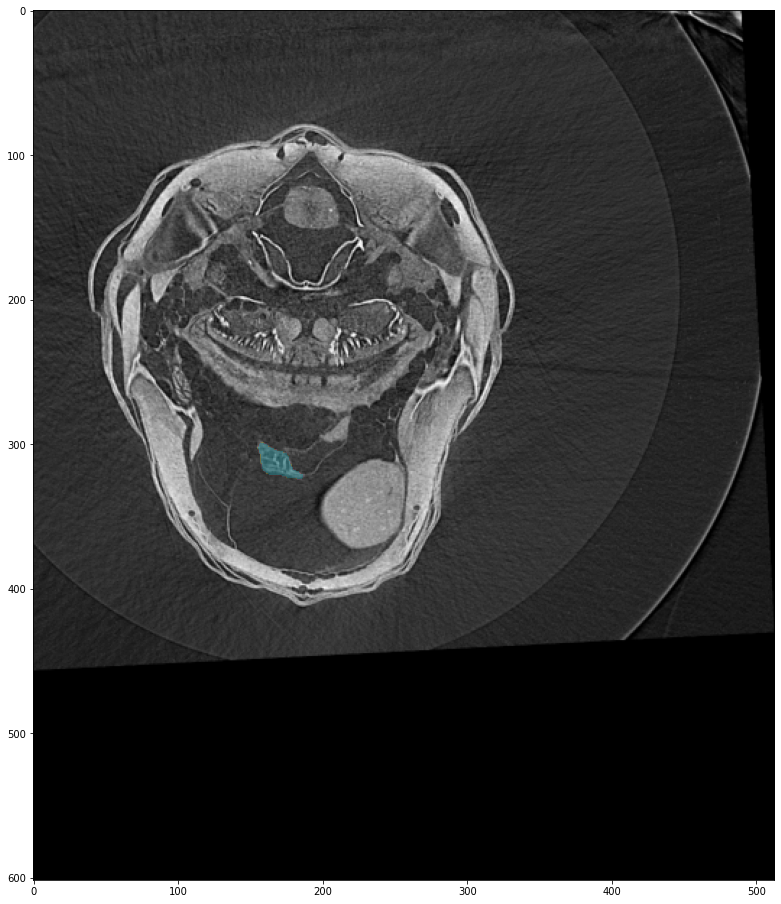

[0 0 0]


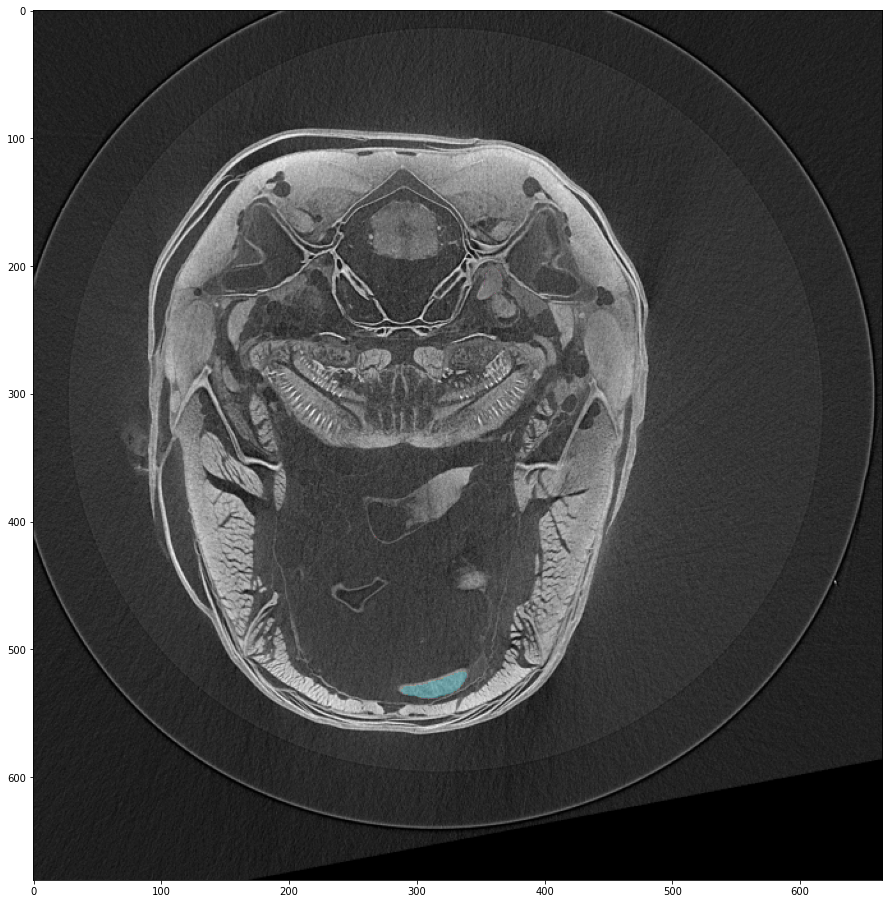

[0 0 0]


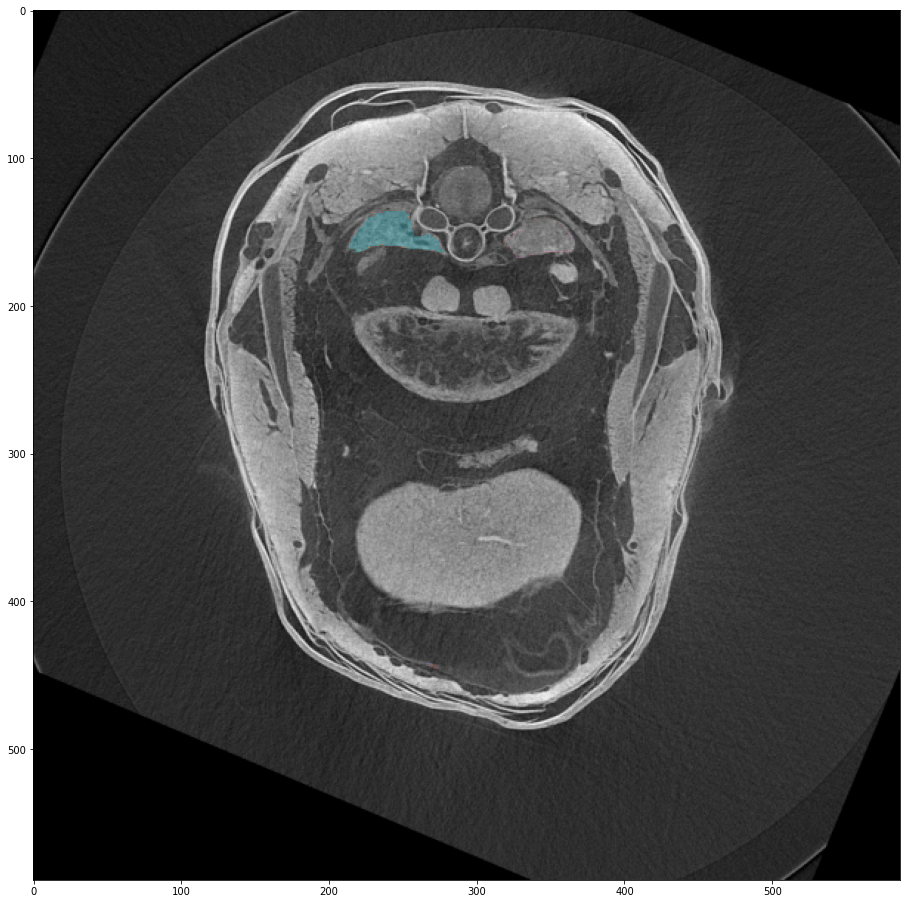

[0 0 0]


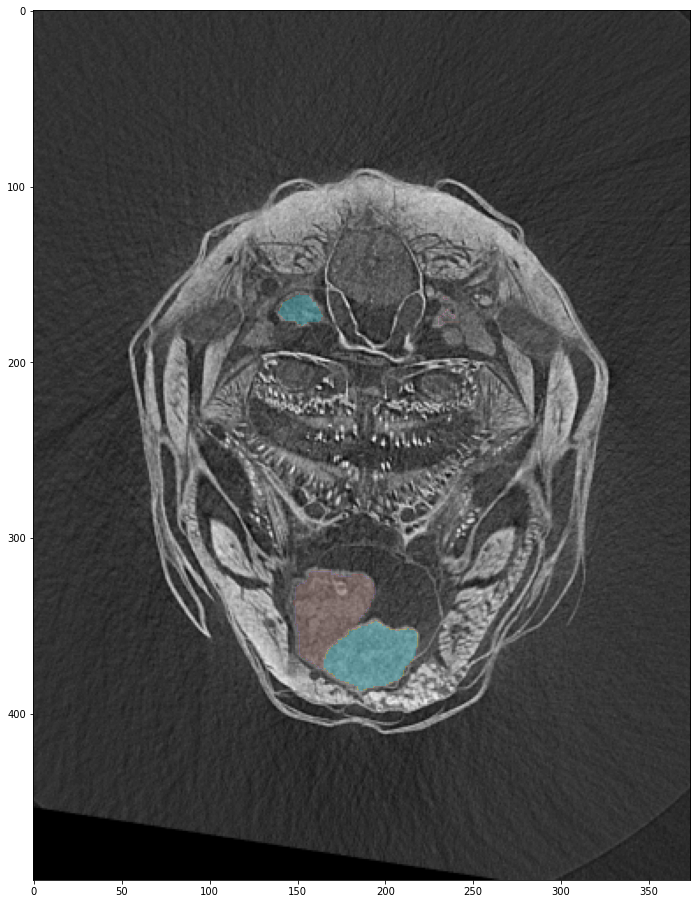

[0 0 0]


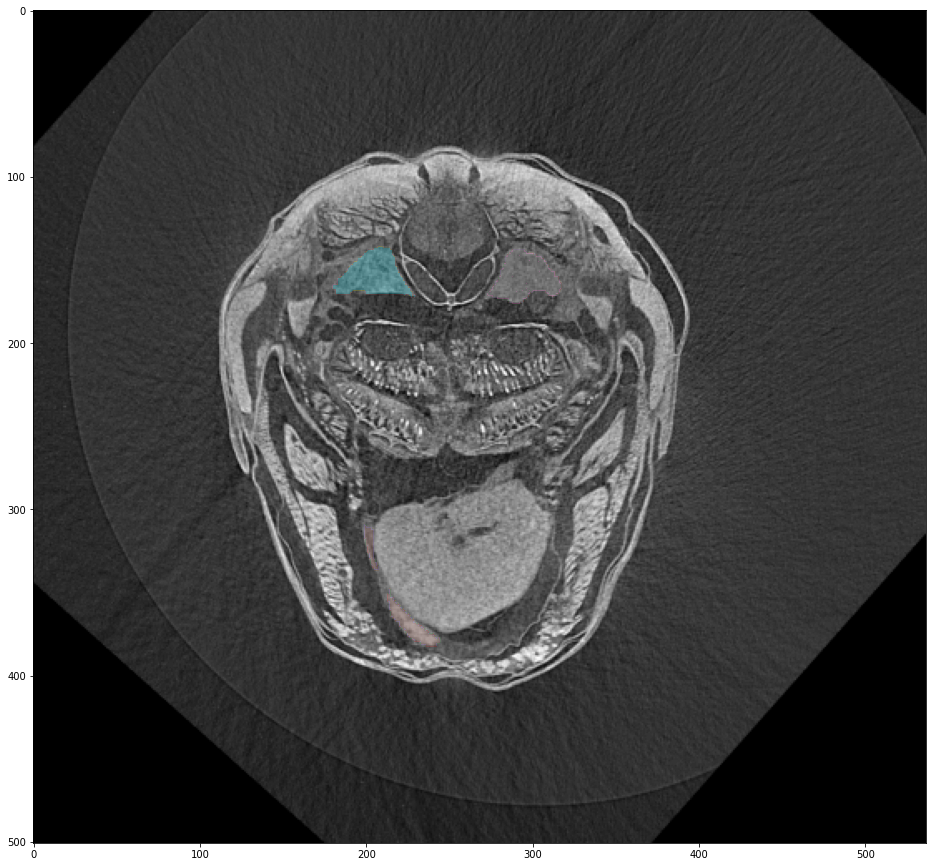

[0 0 0]


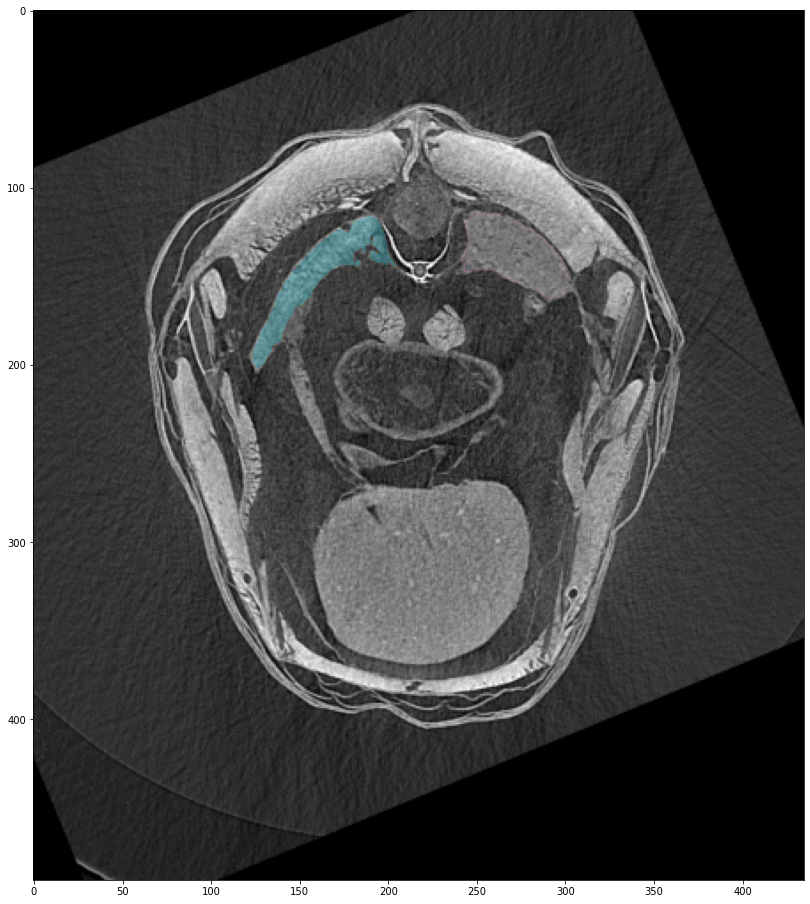

[0 0 0]


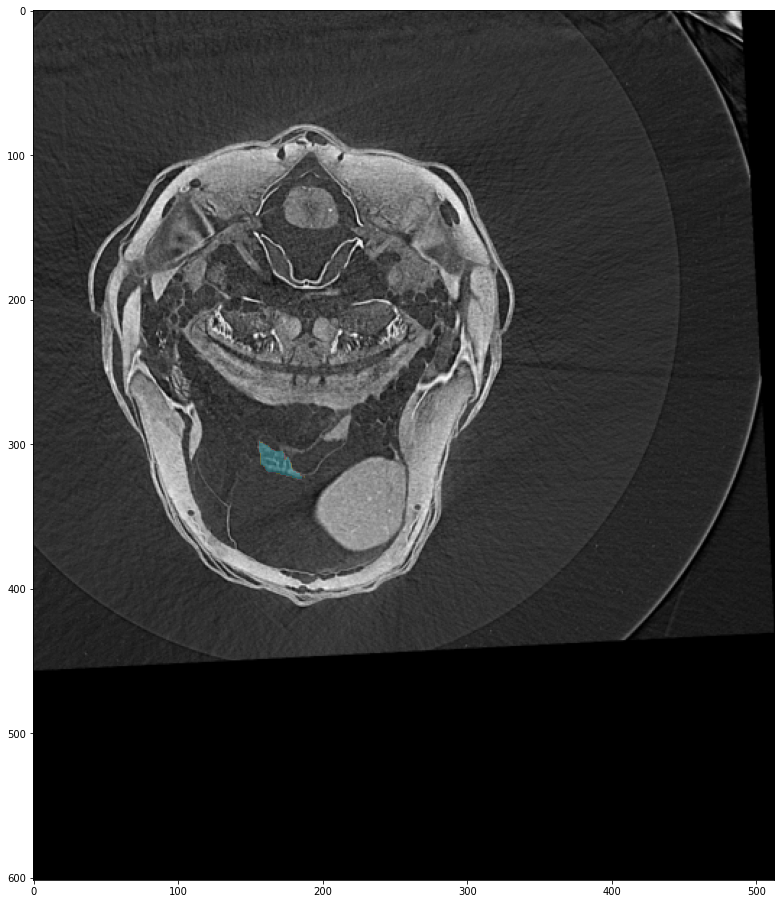

[0 0 0]


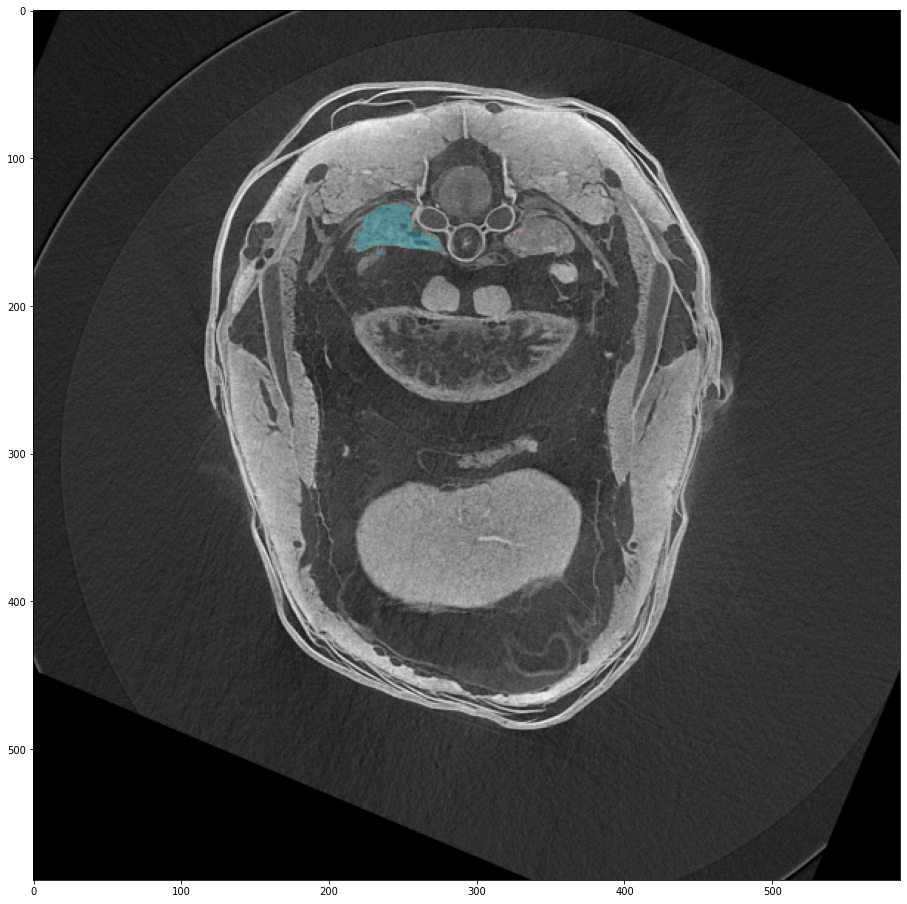

[0 0 0]


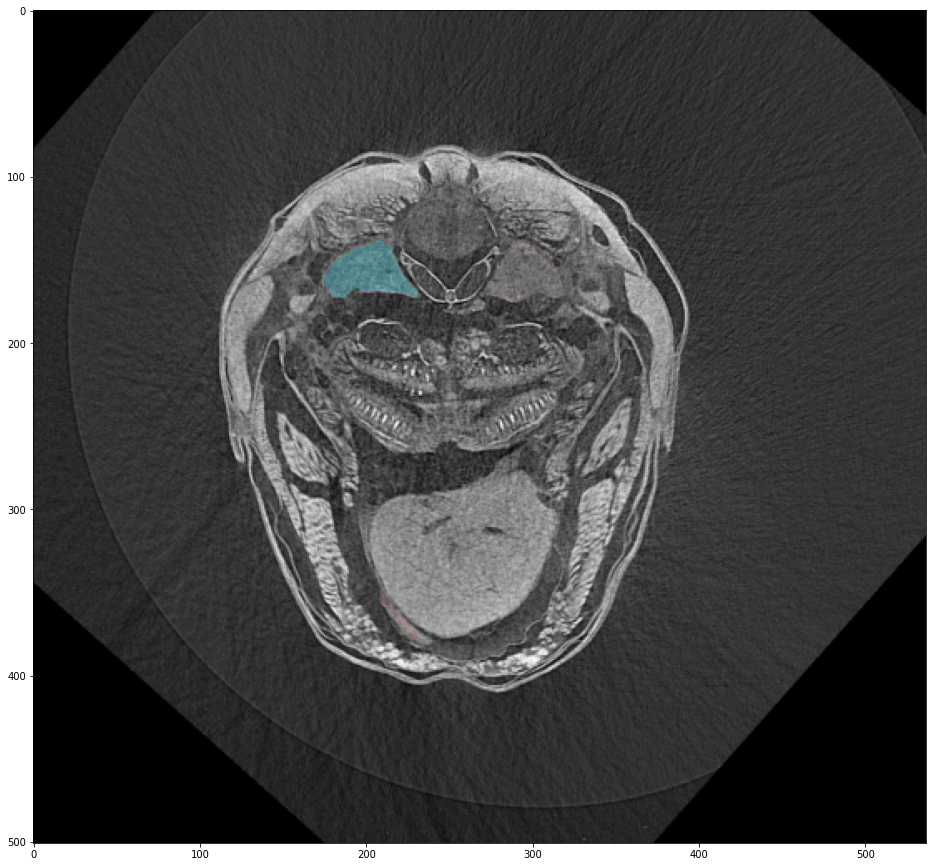

[0 0 0]


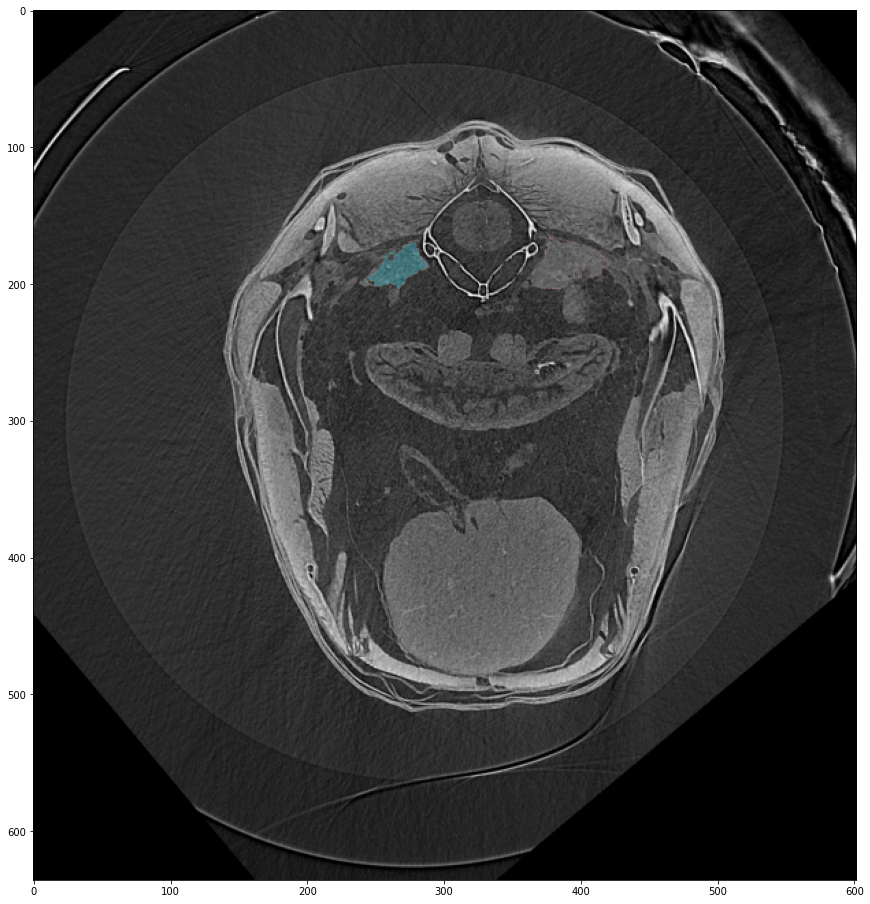

[0 0 0]


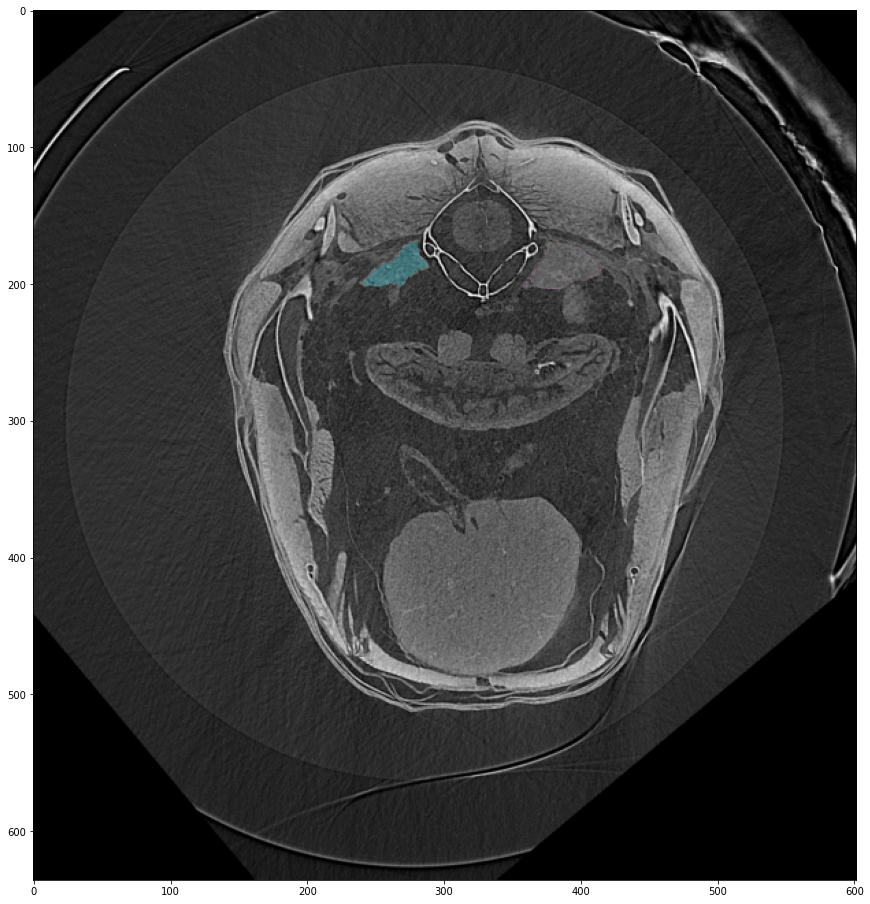

[0 0 0]


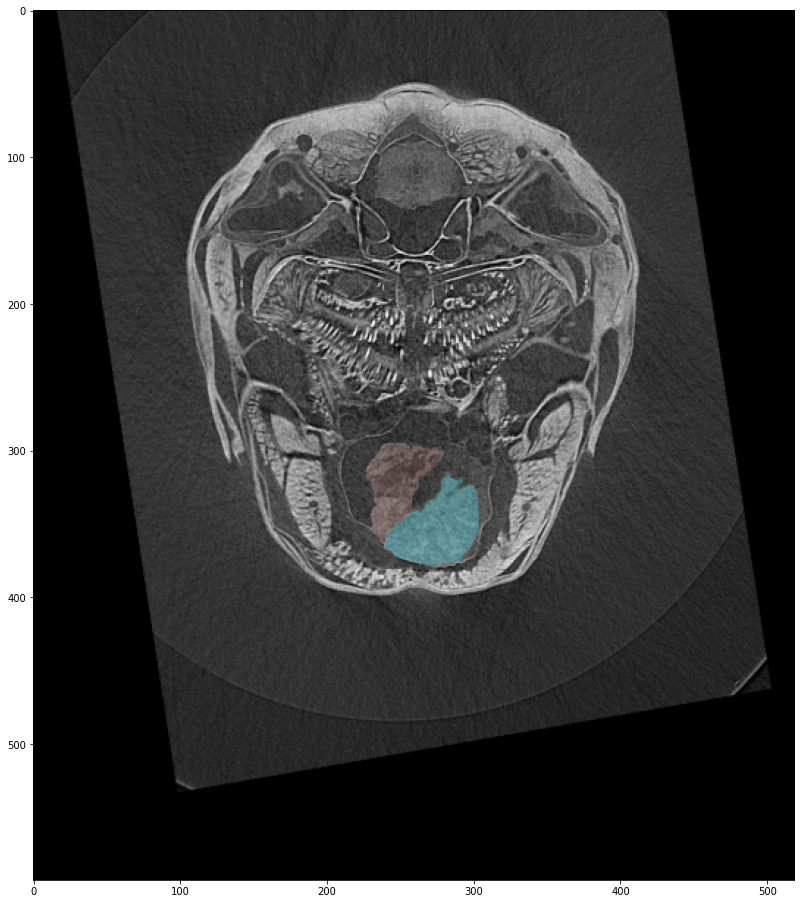

In [369]:
for i in glob('/home/ws/er5241/Repos/markup_reversion/reverted_HeartKidney/*'):
    msk = inner_medload(i)
    uid = re.findall('/.*-(.*).tif', i)[0]
    img = tifffile.imread(f'/mnt/data/machine-learning/medaka_decropped/{uid}.tif')
    ne_slc = np.where(msk.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    
    print(np.array(msk.shape) - np.array(img.shape))
    
    plt.figure(figsize=(16, 16))
    plt.imshow(img[slice_id], cmap='gray')
    plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.3)
    plt.show()